##**Project Introduction**

Customer churn is an important issue to businesses ready to keep customers as well as sustained growth.

The focus of this project on customer churn prediction is on sentiment analysis of comments in Amazon product review.

We detect, through a sentiment model, negative feedback indicating churn risk.

Businesses calculate and visualize the likelihood of churn from every piece of customer feedback. This enables them to warn early so that they can improve satisfaction as well as reduce churn.




##**Business Question**
**How effectively can customer sentiment, as expressed in product reviews, serve as a predictor of potential customer churn?**



Q: **What is the business problem and why is it important?**

A: The business problem is finding out if customer opinion in product reviews is a predictor of customer churn. Churn has immediate impacts on the revenue, customer lifetime value, and reputation of a firm. Identifying early at risk customers can lead to early retention, lowering churn rates and increasing customer satisfaction.

Q: **Why will solving this problem benefit the company?**

A: Early Intervention: The company can offer at-risk customers special offers, more service, or surveying for feedback.

Data-Driven Decisions: Sentiment analysis by feature helps determine areas of need for the product team to address.

Cost Savings: It's more expensive to acquire new customers than to retain old ones, so preventing churn saves marketing and acquisition cost directly.



####Libraries

In [1]:
#collection
import pandas as pd
import requests
from io import StringIO

#preprocessing
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# pip install spacy
# import spacy

#data splitting
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

#vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

#evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_auc_score



# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

True

####Data Collection

# The Kaggle dataset URL
"https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews"

In [2]:
import pandas as pd

# Load the data (adjust path as needed)
data_load = pd.read_csv('/Users/samikshashende/Documents/Projects/Big Data Text Classification/archive/Reviews.csv')

# Or if you put it in a data folder:
# data_load = pd.read_csv('data/Reviews.csv')

# Display basic info
print(f"Dataset shape: {data_load.shape}")
print(f"Columns: {data_load.columns.tolist()}")
print(f"\nFirst few rows:")
print(data_load.head())

Dataset shape: (568454, 10)
Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

First few rows:
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                     

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'HelpfulnessNumerator'}>],
       [<Axes: title={'center': 'HelpfulnessDenominator'}>,
        <Axes: title={'center': 'Score'}>],
       [<Axes: title={'center': 'Time'}>, <Axes: >]], dtype=object)

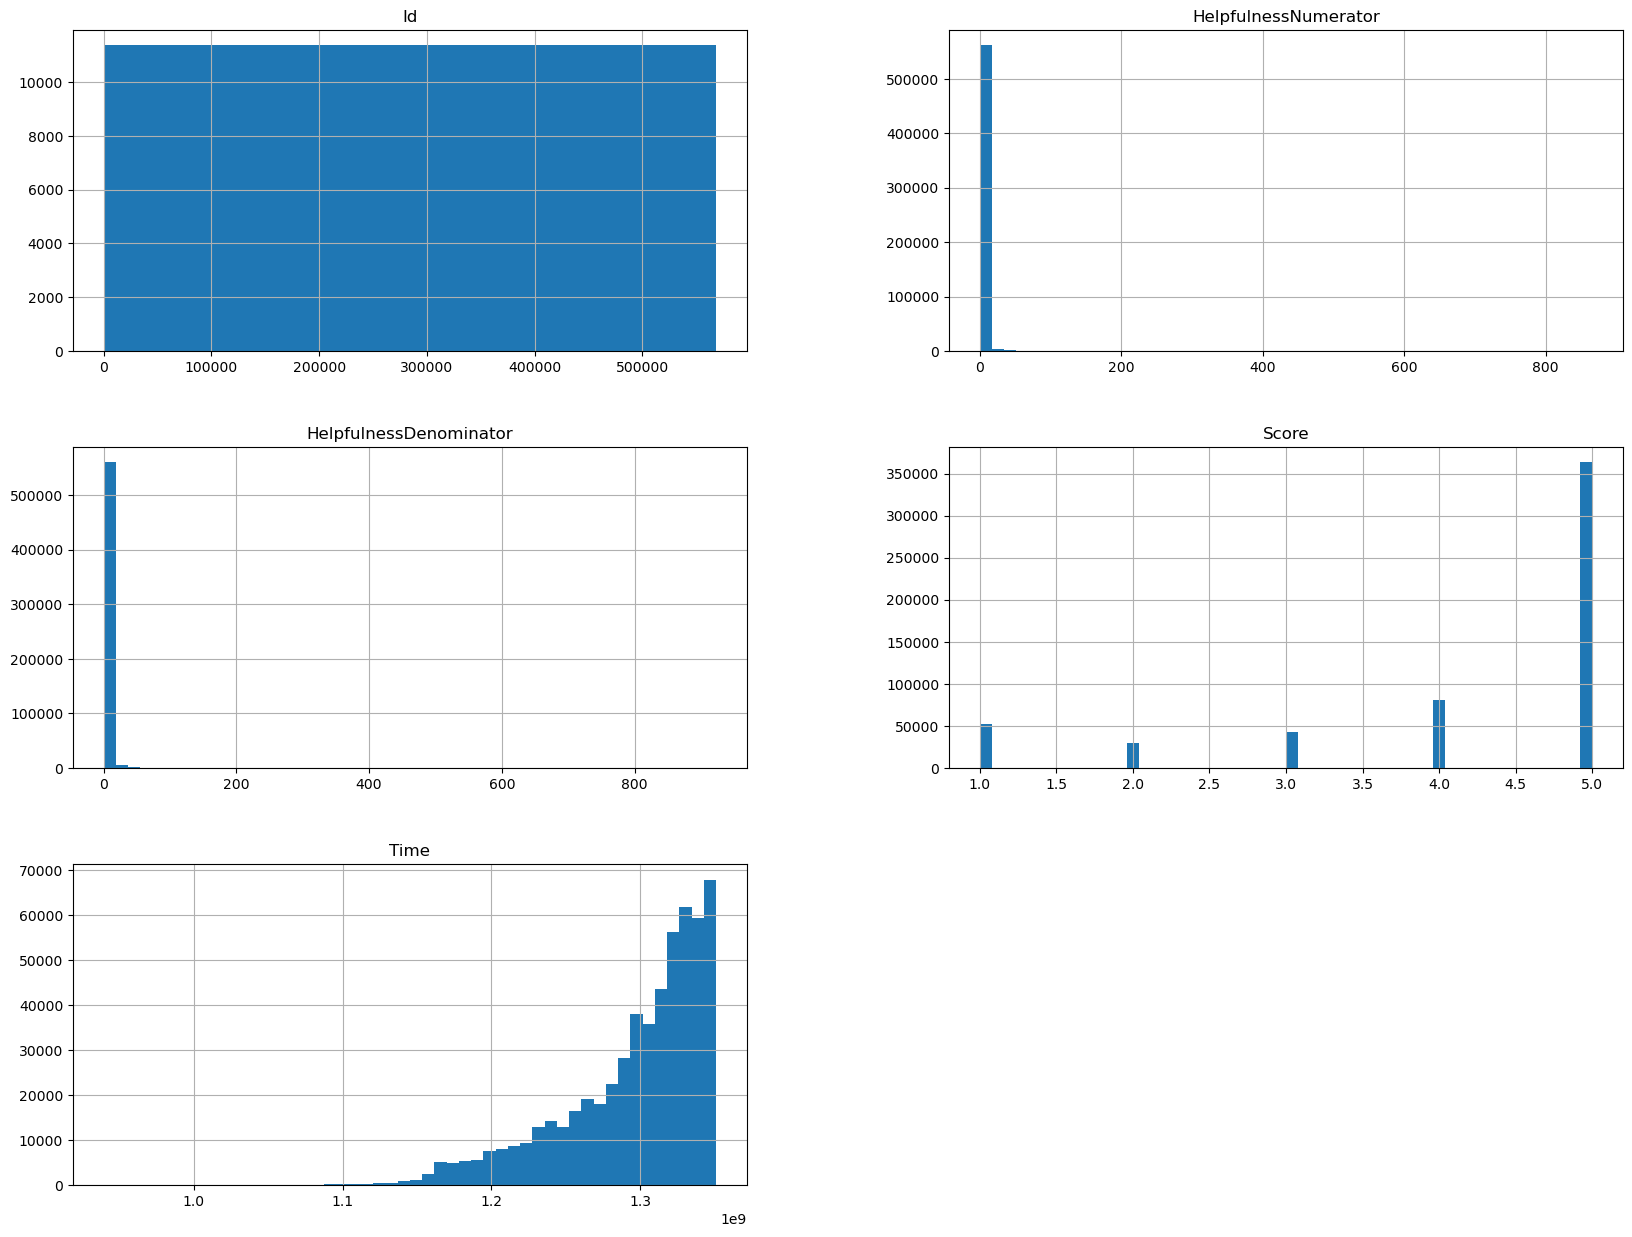

In [3]:
data_load.hist(bins=50, figsize=(20,15))

####Sentiment Labeling

In [4]:
"""
    Map review scores to sentiment and churn risk
    Business Logic:
    - Scores 1-2: Negative sentiment → High churn risk (1)
    - Scores 4-5: Positive sentiment → Low churn risk (0)
    - Score 3: Neutral → Exclude from binary classification
"""
def map_sentiment(score):
    if score <= 2:
        return 0  # Negative
    elif score >= 4:
        return 1  # Positive
    else:
        return None


In [5]:
data_load['Score'] = data_load['Score'].apply(map_sentiment)

data_load.head()
print(f"Churn risk distribution:\n{data_load['Score'].value_counts()}")
print(f"Churn rate: {data_load['Score'].mean():.2%}")

Churn risk distribution:
Score
1.0    443777
0.0     82037
Name: count, dtype: int64
Churn rate: 84.40%


<Axes: title={'center': 'Churn Risk Distribution'}, xlabel='Score'>

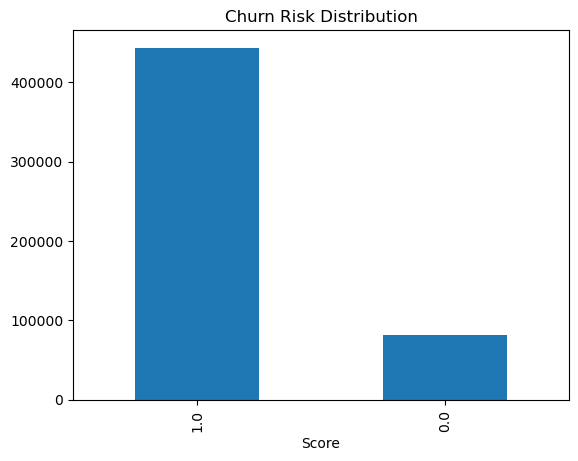

In [6]:
data_load['Score'].value_counts().plot(kind='bar', title='Churn Risk Distribution')

####Text Preprocessing

In [7]:
def preproccesor(text):
  #text = text.lower()
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  tokens_wort = tokenizer.tokenize(text)
  stop_worts = set(stopwords.words('english'))
  filtered_tokens_wort = [token for token in tokens_wort if token not in stop_worts]
  #Normalize the word form
  lemmatizer = WordNetLemmatizer()
  normalized_tokens_wort = [lemmatizer.lemmatize(token) for token in filtered_tokens_wort]
  return " ".join(normalized_tokens_wort)

In [8]:
data_load['preprocessed_overview'] = data_load['Text'].apply(preproccesor)
data_load.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_overview
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,I bought several Vitality canned dog food prod...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled Jumbo Salted Peanuts p...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,This confection around century It light pillow...


####Splitting data into training and testing set

In [9]:
x_data = data_load['preprocessed_overview']
y_data = data_load['Score']


In [10]:
x_data_train, x_data_test, y_data_train, y_data_test = sklearn.model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [11]:
print("X_train_Shape : ", x_data_train.shape)
print("X_test_Shape : ", x_data_test.shape)
print("Y_train_Shape : ", y_data_train.shape)
print("Y_test_Shape : ", y_data_test.shape)

X_train_Shape :  (454763,)
X_test_Shape :  (113691,)
Y_train_Shape :  (454763,)
Y_test_Shape :  (113691,)


###Feature Engineering

In [12]:
print("X_train: ",x_data_train.isna().sum().sum())

print("y_train :", y_data_train.isna().sum().sum())

X_train:  0
y_train : 34155


In [13]:
#Simple Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
y_data_train = pd.Series(imputer.fit_transform(y_data_train.values.reshape(-1, 1)).ravel())
y_data_test = pd.Series(imputer.transform(y_data_test.values.reshape(-1, 1)).ravel())

In [14]:
y_data_train.isna().sum().sum()

np.int64(0)

In [15]:
vecto = TfidfVectorizer(tokenizer=preproccesor)
vecto.fit(x_data_train)

x_train_TF = vecto.transform(x_data_train)
x_test_TF = vecto.transform(x_data_test)

print(x_train_TF.shape)
print(x_test_TF.shape)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(454763, 57)
(113691, 57)


### Training The odel

In [16]:
#Gradient Boosting Classifier Model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(x_train_TF, y_data_train)

#Evaluating the model
y_pred_gb = gb_model.predict(x_test_TF)

print("Gradient Boosting Classifier:")
print(f"Accuracy: {accuracy_score(y_data_test, y_pred_gb)}")
print("F1_Score :")
print(f1_score(y_data_test, y_pred_gb))


KeyboardInterrupt: 

In [17]:
#Random Forest Classifier Model
gb_model = RandomForestClassifier(random_state=42)
gb_model.fit(x_train_TF, y_data_train)

#Evaluating the model
y_pred_gb = gb_model.predict(x_test_TF)

print("Random Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_data_test, y_pred_gb)}")
print("F1_Score :")
print(f1_score(y_data_test, y_pred_gb))


Random Forest Classifier:
Accuracy: 0.913308881089972
F1_Score :
0.9518759399230484


In [ ]:
#SVM
svm_model = SVC(random_state=42)
svm_model.fit(x_train_TF, y_data_train)

# ###Evaluating the model using the cleaned test data
y_pred_svm = svm_model.predict(x_test_TF)

print("SVM Classifier:")
print(f"Accuracy: {accuracy_score(y_data_test, y_pred_svm)}")
print(" F1-Score:")
print(f1_score(y_data_test, y_pred_svm))

In [ ]:
#Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(x_train_TF, y_data_train)

#Evaluating the model using the cleaned test data
y_pred_nb = nb_model.predict(x_test_TF)
print("Naive Bayes Classifier:")
print(f"Accuracy: {accuracy_score(y_data_test, y_pred_nb)}")
print(" F1-Score:")
print(f1_score(y_data_test, y_pred_nb))

After checking the models, we chose to go with Naive Bayes and SVM since,
computational time for Gradient Boosting Classifier was more than 2 hours whereas it took lesser time for the other two.
Therefore, keeping computational power factor in into consideration we went ahead with Naive Bayes and SVM.

In [ ]:

models = {


        'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.5, 1.0]
        }
    },


       'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.5, 1],
            'kernel': ['linear','rbf'],
            'gamma': ['scale']
        }
    },


}

The feature matrix from TF-IDF is usually very large (high dimensionality), which slows down models like SVM.
While tuning the parameters on this dataset, each cross validation took huge amont of time. That's why
 using a smaller sample of the data for tuning and scale up later was the solution I tried.

In [ ]:
# Using smaller sample for faster tuning
x_sample = x_data_train.sample(frac=0.2, random_state=42)
y_sample = y_data_train.sample(frac=0.2, random_state=42)

# Vectorize the sampled data
x_sample_TF = vecto.transform(x_sample)

In [ ]:
# Train and evaluate models
results = {}
best_models = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, config in models.items():
    print(f"\nTraining {name} with RandomizedSearchCV...")


    randomized_cv = RandomizedSearchCV(
        estimator=config['model'],
        param_distributions=config['params'],
        n_iter=5,
        cv=2,
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    randomized_cv.fit(x_sample_TF, y_sample)

In [ ]:
#Store the best model
best_model = randomized_cv.best_estimator_

print(f"Best parameters for {name}: {randomized_cv.best_params_}")
print(f"Best F1 Score for {name}: {randomized_cv.best_score_}")


In [ ]:
#Splitting into Validation
x_final_test, x_validation, y_final_test, y_validation = train_test_split(x_test_TF, y_data_test, test_size=0.2, random_state=42)

In [ ]:
y_val_pred = best_model.predict(x_validation)

In [ ]:
#check accuracy and f1 score
accuracy = accuracy_score(y_validation, y_val_pred)
f1 = f1_score(y_validation, y_val_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Choosing the best model with best params, the final evaluation will be done on final test set.

###Evaluation on Final test set

In [ ]:

    # Predictions on test set
    y_pred = randomized_cv.best_estimator_.predict(x_final_test)
    y_pred_proba = randomized_cv.best_estimator_.predict_proba(x_final_test)[:, 1]


###Evaluations

In [ ]:
    # Calculate metrics
    accuracy = accuracy_score(y_final_test, y_pred)
    precision = precision_score(y_final_test, y_pred)
    recall = recall_score(y_final_test, y_pred)
    f1 = f1_score(y_final_test, y_pred)
    auc = roc_auc_score(y_final_test, y_pred_proba)

    results[name] = {
        'best_params': randomized_cv.best_params_,
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'test_auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"\n{name} Results:")
    print(f"Test recall: {recall}")
    print(f"Test F1 Score: {f1:.4f}")

In [ ]:
print(f"\n" + "="*60)
print(f"DETAILED EVALUATION - SVM Model")
print("="*60)

# Access results for the SVM model using its name as the key
y_pred_best = results['SVM']['predictions']
y_pred_proba_best = results['SVM']['probabilities']

# Classification Report
print("\nClassification Report:")
print(classification_report(y_final_test, y_pred_best,
                          target_names=['No Churn Risk', 'Churn Risk']))

# Confusion Matrix
cm = confusion_matrix(y_final_test, y_pred_best)
print(f"\nConfusion Matrix:")
print("Predicted:    No Churn    Churn Risk")
print(f"No Churn:        {cm[0,0]:>6}        {cm[0,1]:>6}")
print(f"Churn Risk:      {cm[1,0]:>6}        {cm[1,1]:>6}")

The model rightly identified most of the churn-risk customers, which is great for early intervention. However, it also wrongly signaled a significant number of loyal customers as likely to churn.

This can lead to wastage of effort or unwanted retention offers. The model, overall, is good at identifying churn risk but needs further refinement to remove false alarms and increase business efficiency.

###Prediction

In [ ]:
overview = ["It was okay, overall good.","The taste was wonderful, will definately order again.","its worst"]
overview_tf = vecto.transform(overview)
prediction = model.predict(overview_tf)
print(f"The predicted sentiments for the overview about product are: {prediction}")

In [ ]:
#Churn Visualization
#Calculate overall churn rate
churn_rate = (y_final_test.values == 0).sum() / len(y_final_test)
print(f"Overall Churn Rate: {churn_rate:.2%}")

plt.figure(figsize=(6, 4))
plt.bar(['Churn Rate'], [churn_rate], color='red')
plt.ylabel('Churn Probability')
plt.title('Overall Churn Probability Based on Negative Sentiment')
plt.ylim(0, 1)
plt.show()

The risk of churn is approximately 27-30%, or roughly one among every three to four customers who write negative feedback is at risk of churn.

That is an indication of strong correlation between customer sentiment and risk of churn.




###Conclusion
Customer sentiment within review sentiments is a good predictor of churn. Negative sentiments indicate a churn risk of around 27-30%, providing companies with an advance warning of potentially churning customers. While the model predicts churn quite well, it also mispredicts some loyal customers, which suggests room for improvement in accuracy. Sentiment analysis can play a big role in preventing churn proactively.

###**Strengths**:
Direct Business Fit: Provides fast, useful insights by utilizing actual product reviews to forecast customer attrition.

**Fast & Scalable Models**: SVM and Naive Bayes are straightforward, dependable, and effective with text data.

**Clear Visuals**: Simple bar charts make it simple to monitor churn probability.

###**Restrictions**:
**Narrow View**: Ignores other churn factors, such as purchase history, and concentrates only on the review text.
To put it bluntly, negative reviews imply churn risk but do not prove it.

**Lack of Time Tracking**: Does not monitor the evolution of sentiment over time.

**Business Impact**: Identify Customers at Risk Immediately.
Companies can spot dissatisfied clients early.

**Targeted Retention**: Encourages astute customer follow-ups, such as offers of assistance or discounts.

###**Recommendation**
The company should proactively monitor customer feedback to identify at-risk customers with negative sentiment in real time and contact them. Additionally, refining the model to reduce false positives will render retention more efficient and less costly.

In [ ]:
#save model
import joblib
joblib.dump(model, 'sentiment_churn_model.joblib') 